# Test technique de 111 capital

In [1]:
%config Completer.use_jedi = False # Pour rendre l'auto-completion dans jupyter plus rapide

import pylab as pb
import scipy.stats as scs
import numpy as np

from Classes.TimeSeriesClasses import TimeSeriesIndexedByDatesAndSeconds
from Classes.Tools import Tools

## Description du data pipeline

J'ai décidé d'indexer les données par le couple *(date, t)* où :
 * *date* est la date du jour 
 * et *t* est le temps écoulé en seconde depuis la première entrée du jour.
 
En effet, les time series ne sont pas continues. Chaque jour, excepté les mardis et mercredis, elles donnent toutes les 10 secondes les valeurs des cours pendant exactement 3h30 à partir de 14h30 ou 15h30. Ainsi la longueur des time series et les pas de temps sont fixes.

De plus, dans la suite, je montre que la correlation des time series ne dépassent pas en moyenne l'heure et que la correlation entre le début d'une journée et la fin du jour précédant sont très peu corrélés. Cette assertion n'est pas étonnante étant donné que des heures, voire des jours séparent chaque series quotidiennes.

Les time series sont manipulées à travers la classe *TimeSeriesIndexedByDatesAndSeconds*. L'attribut principale est *data* qui est un DataFrame de pandas contenant toutes les times series. L'attribut *metadata* est un dictionnaire contenant une courte description de chaque colonne. 

In [2]:
train_address = 'Data/train.csv'
test_address = 'Data/test.csv'

TrainTS = TimeSeriesIndexedByDatesAndSeconds(train_address, 'train data set')
TestTS = TimeSeriesIndexedByDatesAndSeconds(test_address, 'test data set')

Voici un morceau de code affichant les metadonnées de *target* et le début de sa time series.

In [3]:
TrainTS.print_metadata_of('target')
TrainTS.data['target'].head()

Metadata on target
  Description: target variable, value to predict


date        t 
2010-01-03  0    -0.2125
            10   -0.2125
            20   -0.2000
            30   -0.1750
            40   -0.0750
Name: target, dtype: float64

Pour ajouter une colonne à *data*, on utilise la méthode *add_new_column* à qui il faut fournir un nom, une description et un tableau de valeurs.

Les données ne prenant pas beaucoup de mémoire vive et étant rapides à calculer, je n'ai pas conçu de méthodes pour écrire en dur les données pour cette exercice.

## Data transformation

Mis à part le temps, nous avons trois variables: le cours de référence, le cours alternatif et la variable target. En fonction de mes besoins, j'applique à ces données différentes transformations dont voici la description.

**Lissage.**
J'utilise la moyenne glissante d'une fenêtre, notée $w$, de taille 590 secondes. Si $P_t$ est la variable à lisser et $L_t$ son lissage, alors $L_t = \frac{1}{w} \sum_{s=t-w}^t P_{s}$ .

La variable *target* étant visiblement déjà lissée, je n'applique le lissage que sur les variables dérivées des cours de référence et alternatif. Les données lissées sont nommées par leur nom plus le préfixe *smoothed*. Par exemple, *ref_price* lissé est appelé *smoothed_ref_price*.

In [15]:
TrainTS.compute_smoothing_of_ref_and_alt_price()
TestTS.compute_smoothing_of_ref_and_alt_price()

**Somme cumulée.**
Visiblement *target* est la première différence d'un cours, i.e. la différence entre la valeur du cours à un instant donnée et sa valeur à l'instant précédant. Si $P_t$ dénote le cours à l'instant $t$ et $D_t$ sa première différence, nous avons $D_t=P_t - P_{t-dt}$, avec $dt$ le pas de temps (égale à 10s dans notre cas).

Pour récupérer, un cours à partir de sa première différence, il suffit de calculer sa somme cumulée.

Par soucis de cohérence avec le nommage des cours de référence et alternative, j'appelle le *cours de target* la somme cumulée de *target*.

In [16]:
TrainTS.compute_target_price()
TestTS.compute_target_price()

**Première différence.** A l'inverse, je calcule la première différence des cours de référence et alternatif. La première différence d'une variable est nommée par son nom plus de suffix *diff*. Par exemple, la première différence de *ref_price* est appelé *ref_price_diff*.

In [17]:
TrainTS.compute_first_diff_of_ref_and_alt_price()
TestTS.compute_first_diff_of_ref_and_alt_price()

**Normalisation.** Je normalise une variable en divisant chaque jour par l'écart-type de la première heure de la journée. Remarquons que pour la première heure, les valeurs d'une variable normalisée sont dépendantes de données dans le future par rapport à elles. Pour ne pas risquer de les utiliser lors de prédiction, je fixe la première heure de chaque jour des variables lissées comme nan (Not A Number). Les données normalisées sont nommées par leur nom plus le prefix *normalised*. Par exemple, la normalisation de *ref_price* est appelée *normalised_ref_price*.

In [18]:
TrainTS.compute_normalization_of_target_alt_and_ref_price()
TestTS.compute_normalization_of_target_alt_and_ref_price()

## Analyses préliminaires

Avant toute chose, j'ai passé du temps à visualiser et analyser les données pour mieux connaitre les données. Cette partie résume mes découvertes les plus intéressantes.

### Similarité entre target et le prix alternatif

La première remarque est que la somme cumulée normalisée de *target* est très proche du cours alternatif lissé et normalisé avancé de 5 minutes. Il y a donc peu de chance que le cours alternatif puisse être significatif dans la prédiction de *target*. De plus, le cours de référence semble corrélé avec le cours de *target*, mais là aussi avec un retard de 5 minutes. Ceci est confirmé par les résultats dans la partie *Corrélation*. Ainsi le cours de référence risque aussi de ne pas apporter grand chose dans la prédiction de *target*.

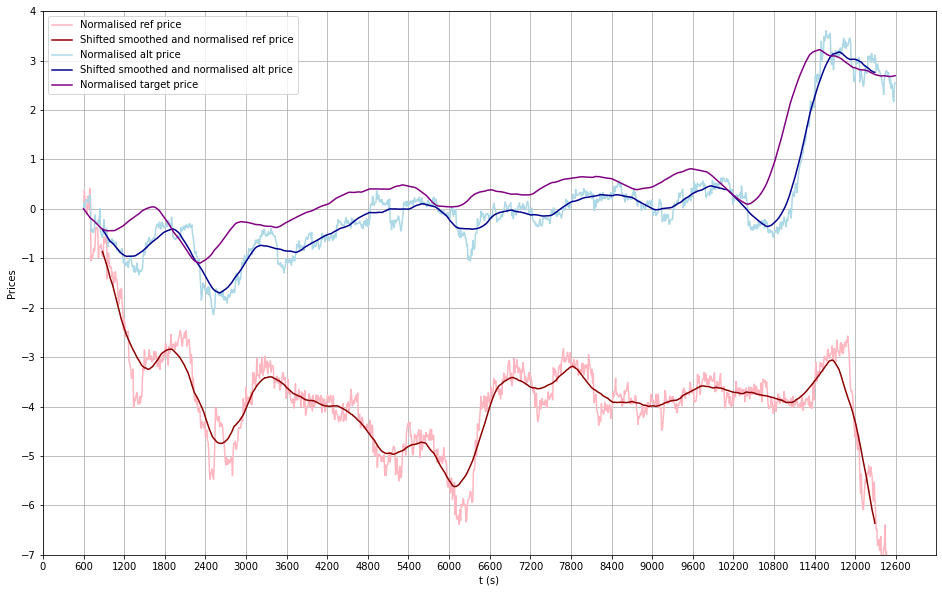

In [8]:
date = TrainTS.date_list[1]
df = TrainTS.data.loc[date, :]
    
fig, ax = pb.subplots(figsize=(16, 10))
val0 = df['normalised_ref_price'].dropna().iloc[0]
df_to_plot = df['normalised_ref_price'] - val0
df_to_plot.plot(ax=ax, c='lightpink', label='Normalised ref price')
df_to_plot = df['smoothed_normalised_ref_price'] - val0
df_to_plot.shift(-30).plot(ax=ax, c='darkred', label='Shifted smoothed and normalised ref price')

val0 = df['normalised_alt_price'].dropna().iloc[0]
df_to_plot = df['normalised_alt_price'] - val0
df_to_plot.plot(ax=ax, c='lightblue', label='Normalised alt price')
df_to_plot = df['smoothed_normalised_alt_price'] - val0
df_to_plot.shift(-30).plot(ax=ax, c='darkblue', label='Shifted smoothed and normalised alt price')

val0 = df['normalised_target_price'].dropna().iloc[0]
df_to_plot = df['normalised_target_price'] - val0
df_to_plot.plot(ax=ax, c='purple', label='Normalised target price')

pb.xticks(range(0, 13000, 600))
pb.yticks(range(-9, 5, 1))
pb.ylim(-7, 4)
pb.xlabel('t (s)')
pb.ylabel('Prices')
pb.grid()

pb.legend()

### Corrélation

La variable *target* a une certaine inertie, i.e. à chaque instant la valeur de target est corrélé avec ses valeurs des temps précédants. La figure suivante montre qu'en moyenne l'autocorrelation quotidienne de *target* atteint 0.5 autour d'un lag de 2800s soit environ 45 minutes.

Sur la même figure, nous pouvons constater qu'effectivement les cours alternatif lissé et normalisé sont trés corrélés avec la somme cumulée normalisée autour du lag -300s, soit un retard autour de 5 minutes. Il y a donc peu de chance que le cours alternatif puisse être significatif dans la prédiction de target.

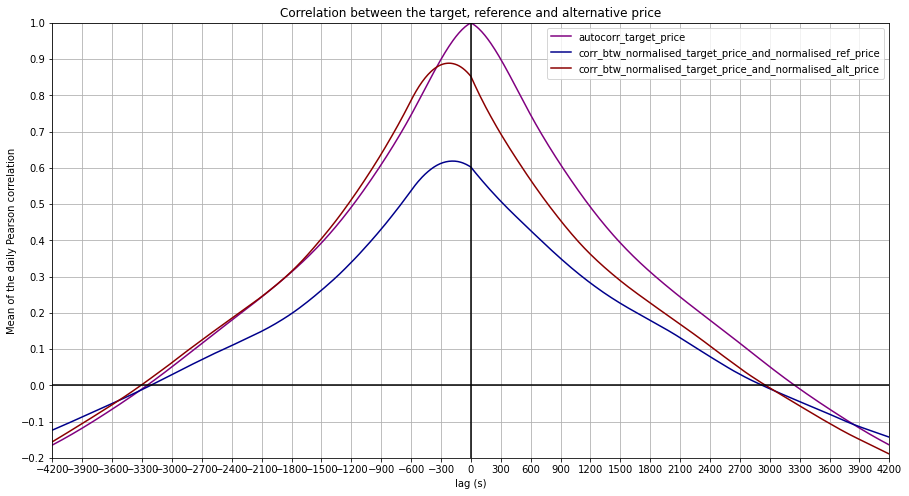

In [9]:
fig, ax = pb.subplots(figsize=(15, 8))

df_corr = TrainTS.get_mean_correlation_between('target_price', 'target_price')
df_corr.plot(ax=ax, c='purple', label='with normalised reference price')

df_corr = TrainTS.get_mean_correlation_between('normalised_target_price', 'normalised_ref_price')
df_corr.plot(ax=ax, c='darkblue', label='with normalised reference price')

df_corr = TrainTS.get_mean_correlation_between('normalised_target_price', 'normalised_alt_price')
df_corr.plot(ax=ax, label='with normalised reference price', c='darkred')

pb.axvline(0, c='k')
pb.axhline(0, c='k')
xlim = 4200
pb.xlim(-xlim, xlim+1)
pb.xticks(range(-xlim, xlim+1, 300));
pb.yticks(np.arange(-1, 1.1, 0.1));
pb.ylim(-0.2, 1)
pb.grid()
pb.xlabel('lag (s)')
pb.ylabel('Mean of the daily Pearson correlation');
pb.title('Correlation between the target, reference and alternative price')
pb.legend();

## Critère de performance

Le critère de performance que je choisis est tout simplement la distance euclidienne entre *target* et sa prédiction. Si $T_t$ est la valeur de target à l'instant $t$ et $T_t^*$ sa prédiction, alors le critère de performance noté $C$ vaut $C=\frac{1}{|S|}\sqrt{\sum_{t\in S} (T_t-T_t^*)^2}$, où $S$ est l'ensemble des instants pour lesquels *target* et sa prédicition sont définis et $|S|$ la taille de $S$.

## Premier modèle simple

### Description

Avant de me lancer dans des modèles compliqués, j'ai essayé un modèle simple qui exploite l'inertie de *target*. En effet, la moyenne des valeurs précédentes de *target* suffit peut-être à donner une bonne estimation de *target*.

Le modèle, nommé *modèle d'inertie*, prend en argument la time series *target* notée $T_t$ à l'instant $t$ et une taille de fenêtre notée $w$. Si $T_t^*$ est la valeur prédit à l'instant $t$, le modèle donne : $T_{t+dt}^* = 1/w \sum_{s=t-w}^t T_{s}$.

**Remarque.** Si on prend $w=dt=$10s, cela revient à prédire la valeur de *target* à l'instant $t$ par sa valeur à l'instant précédant $t-dt$. 

### Implémentation et calcul

In [10]:
from Classes.ModelClasses import InertiaModels
InertiaModelOfTrainTS = InertiaModels(TrainTS)
InertiaModelOfTestTS = InertiaModels(TestTS)

La classe *InertiaModels* prend en argument un objet de class *TimeSeriesIndexedByDateAndSecondes*. La méthode *prediction* prédit *target* pour une taille de fenêtre donnée (paramètre *window*). Elle stocke cette prédiction dans une colonne de l'objet TimeSeries nommée automatiquement.

In [13]:
for window in [10, 120, 240, 500]:
    InertiaModelOfTrainTS.prediction(window=window)
    TrainTS.data['inertia_w%s_predicted_target' % window].iloc[1000:1005]
    
    InertiaModelOfTestTS.prediction(window=window)
    TestTS.data['inertia_w%s_predicted_target' % window].iloc[1000:1005]

/home/line/venv_python3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


A partir de la prédiction de *target*, je reconstitue le cours de *target* en sommant la valeur prédite avec la valeurs réelle précédante du cours. Si $T_t$ est la valeur réelle de *target* à l'instant $t$, $T_t^*$ est la valeur prédite de *target*, $P_t$ la valeur réelle du cours de target et $P_t^*$ la valeur prédite du cours de target, alors $P_t^* = P_{t-dt}+T_t^* = \sum_{s=0}^{t-dt} T_s+T_t^*$.


In [19]:
for window in [10, 120, 240, 500]:
    InertiaModelOfTrainTS.compute_prediction_of_target_price(window=window)
    InertiaModelOfTestTS.compute_prediction_of_target_price(window=window)

### Visualisation des résultats

La figure suivante montre le cours de *target* pendant le premier jour du training set et ses prédictions avec des fenêtres de 10, 120 et 240 secondes. Les deux figures suivantes sont des zooms. Sans surprise le modèle fonctionne bien quand *target* varie peu, mais est moins précis quand *target* change de signe. J'observe que plus la fenêtre du modèle est grande, plus les prédictions ont une "inertie" et prennent du temps à revenir aux valeurs réelles de *target* après un changement.

In [20]:
def plot_inertia_model_prediction(ts, title, xlim=None, ylim=None):
    date = ts.date_list[0]
    color_dict = Tools().get_list_color('Blues_r', [10, 120, 240, 500, 0, 0])


    fig, ax = pb.subplots(figsize=(16, 10))
    ts.data['target_price'].loc[date, :].loc[date, :].plot(ax=ax, lw=3, c='darkred')
    for window in [10, 120, 240, 500]:
        df = ts.data['inertia_w%s_predicted_target_price' % window]
        df.loc[date, :].loc[date, :].plot(
            ax=ax, c=color_dict[str(window)], label='Prediction with window %s s' % window);
    pb.xlim(xlim)
    pb.ylim(ylim)
    pb.xlabel('t (s)')
    pb.ylabel('Cours')
    pb.title(title)
    pb.legend();

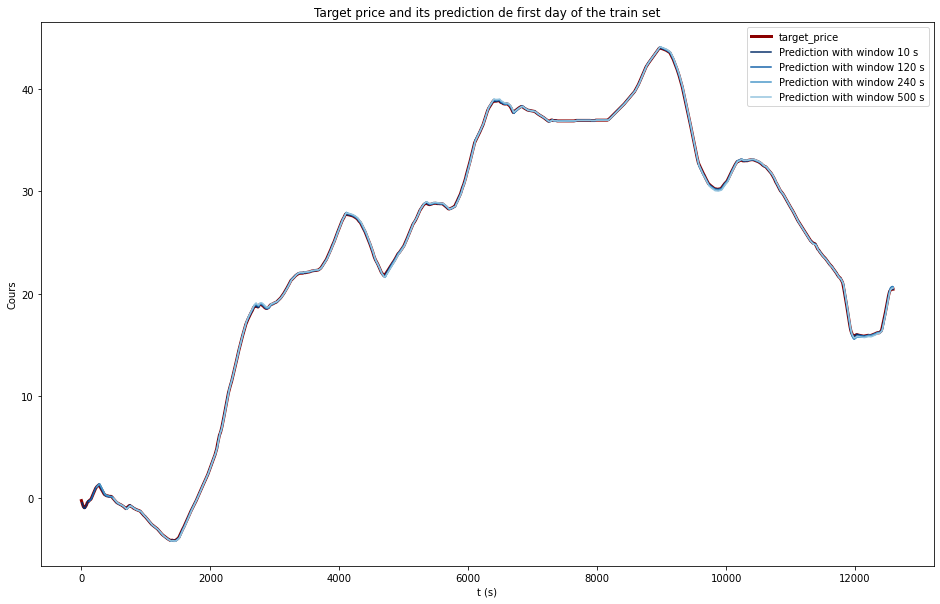

In [21]:
plot_inertia_model_prediction(TrainTS, 'Target price and its prediction de first day of the train set')

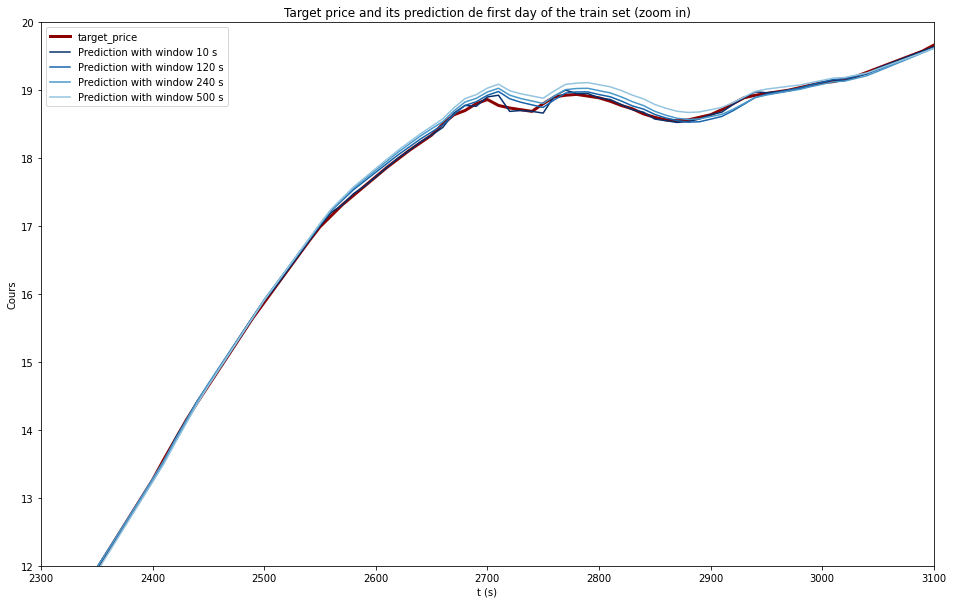

In [22]:
plot_inertia_model_prediction(
    TrainTS, 'Target price and its prediction de first day of the train set (zoom in)', (2300, 3100), (12, 20))

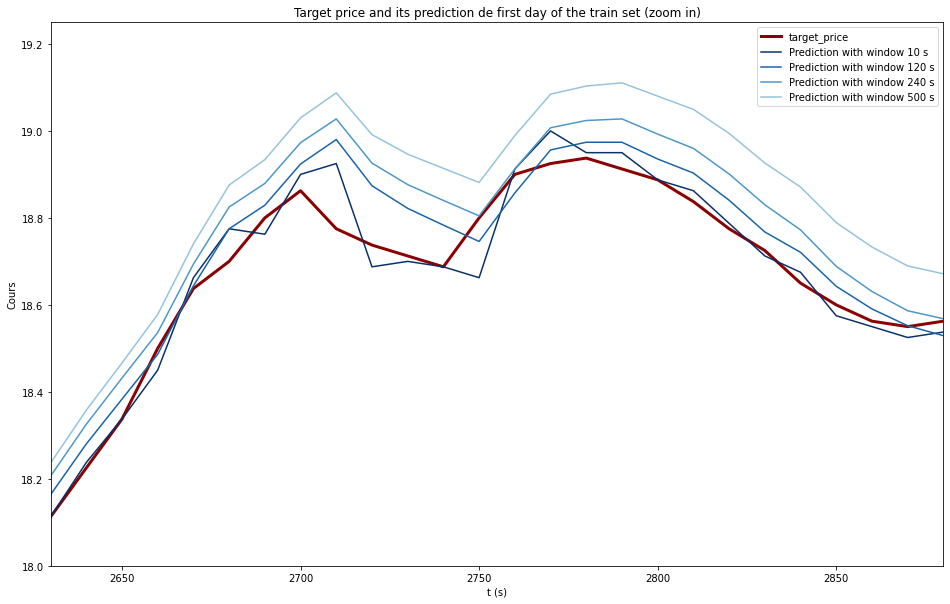

In [23]:
plot_inertia_model_prediction(
    TrainTS, 'Target price and its prediction de first day of the train set (zoom in)', (2630, 2880), (18, 19.25))

Les figures suivantes sont les mêmes courbes que précédement mais pour le premier jour du test set.

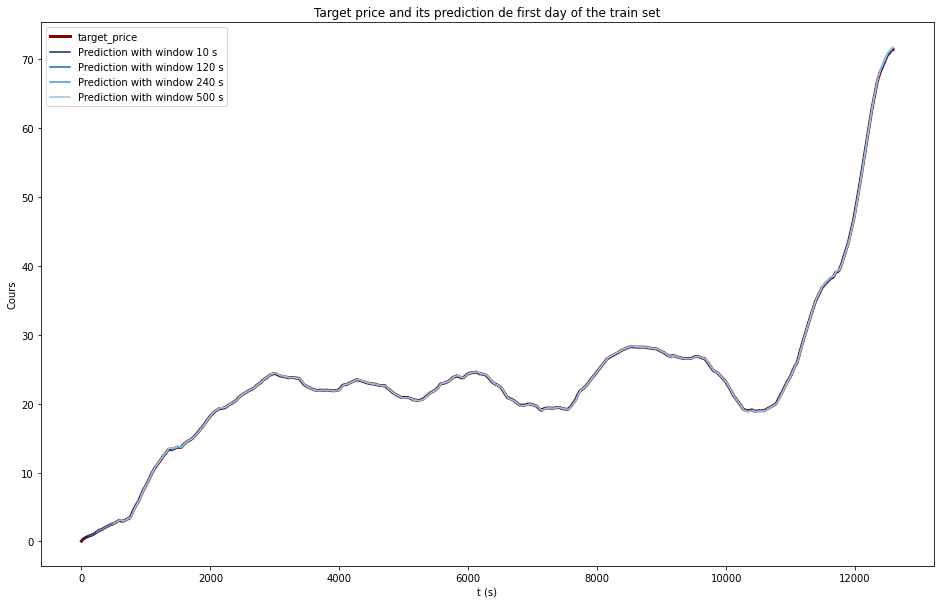

In [24]:
plot_inertia_model_prediction(TestTS, 'Target price and its prediction de first day of the train set')

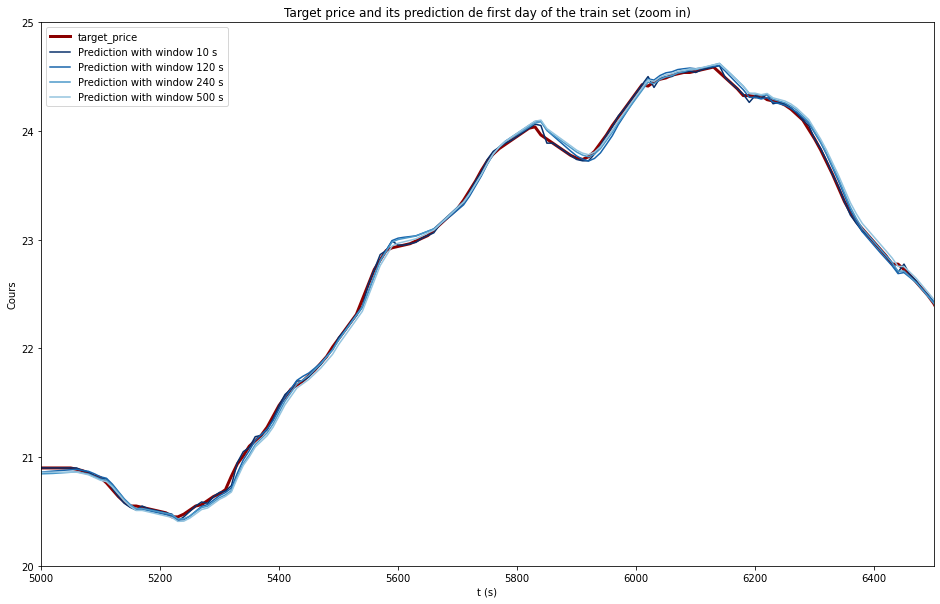

In [25]:
plot_inertia_model_prediction(
    TestTS, 'Target price and its prediction de first day of the train set (zoom in)', (5000, 6500), (20, 25))

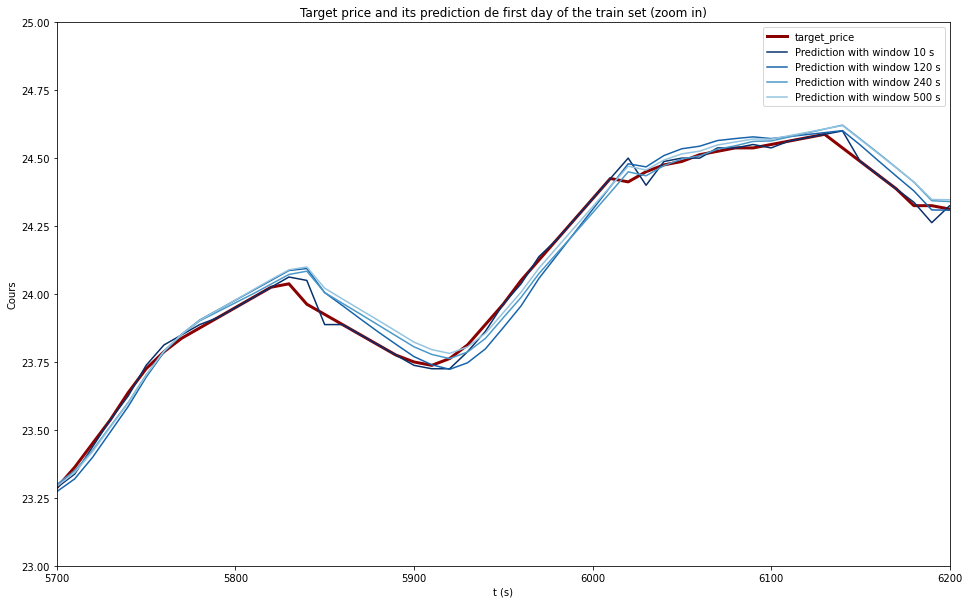

In [26]:
plot_inertia_model_prediction(
    TestTS, 'Target price and its prediction de first day of the train set (zoom in)', (5700, 6200), (23, 25))

### Performance

Dans cette section, nous allons étudier la performance du modèle d'inertie pour différente taille de fenêtre.

In [27]:
from Classes.PerformanceClass import PerformanceClass

Pour des tailles de fenêtre allant de 10s à 600s, je calcule la performance du modèle d'inertie sur les data set train et test.

In [28]:
perf_train_list = []
perf_test_list = []
window_list = list(range(10, 610, 20))
for window in window_list:
    
    InertiaModelOfTrainTS.prediction(window=window)
    df_prediction_target = TrainTS.data['inertia_w%s_predicted_target' % window]
    perf_train_list.append(PerformanceClass().get_euclidean_distance(TrainTS.data['target'], df_prediction_target))
        
    InertiaModelOfTestTS.prediction(window=window)
    df_prediction_target = TestTS.data['inertia_w%s_predicted_target' % window]
    perf_test_list.append(PerformanceClass().get_euclidean_distance(TestTS.data['target'], df_prediction_target))


best_inertia_perf_on_train_set = np.min(perf_train_list)
best_inertia_perf_on_test_set = np.min(perf_test_list)

/home/line/venv_python3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


La figure suivante montre la performance du modèle en fonction de la taille de fenêtre. Sans surprise, plus la fenêtre est grande, plus la distance entre les valeurs réelles et leur prédictions sont éloignées et donc moins le modèle est performant.

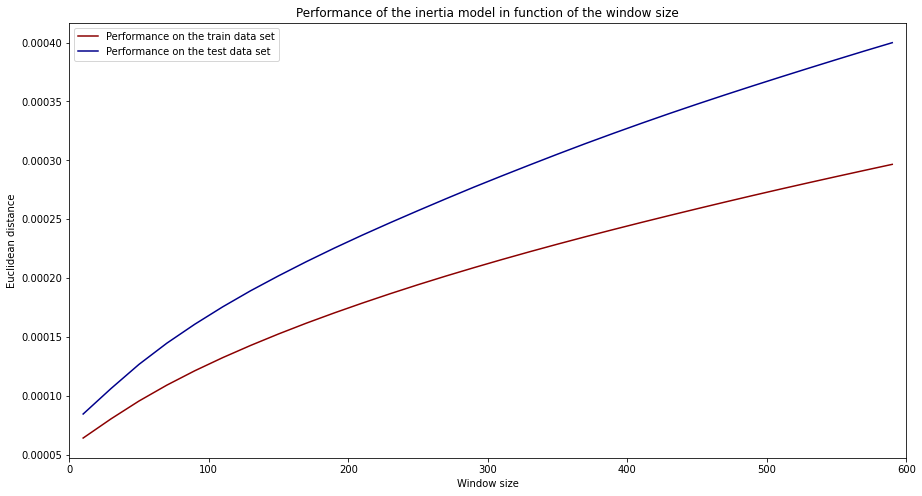

In [29]:
fig, ax = pb.subplots(figsize=(15, 8))
pb.plot(window_list, perf_train_list, label='Performance on the train data set', c='darkred')
pb.plot(window_list, perf_test_list, label='Performance on the test data set', c='darkblue')
pb.xlim(0, 600)
pb.xlabel('Window size')
pb.ylabel('Euclidean distance')
pb.legend();
pb.title('Performance of the inertia model in function of the window size');

### Conclusion

Cette section montre qu'une bonne prediction de target à un instant donné est sa valeur à l'instant précédant.

# Modèle de réseau de neurones

Le modèle d'inertie n'utilise que *target* et non les cours de référence et alternatif. Cette section propose un modèle utilisant les différentes features à l'instant $t-dt$ pour prédire l'instant $t$ via un réseau de neurones.

In [30]:
from Classes.ModelClasses import NeuronalNetworkModels

Parce que plus complexe et possédant plus de paramètres que le modèle d'inertie, un objet de la classe *NeuronalNetworkModels* ne peut prédire que pour un jeu de paramétres fixé. Ainsi il faut créer un objet *NeuronalNetworkModels* pour chaque jeu de paramètres que l'on veut tester.

Le modèle prend en paramètre:
 * le nom du modèle;
 * les train et test set sous la forme d'une *TimeSeriesIndexedByDateAndSeconds*;
 * les noms des features utilisés pour entrainer le réseau de neuronnes;
 * le nom de la variable à prédire, i.e. *target*:
 * une liste d'entiers donnant la taille des couches de neurones (le nombre de couches cachées est donc la longueur de cette liste);
 * le nombre d'époques à effectuer (fixé par défaut à 10);
 * la taille des batchs (fixée par défaut à 1000);
 * et enfin le taux d'apprentissage (learning rate).

Le output du réseau de neurones est la valeur de *target* à l'instant $t$ et son input est le vecteur contenant toutes les valeurs des features à l'instant $t-dt$.

### Choix des features

J'ai testé plusieurs jeux de features pour prédire *target*. Je reporte ici les résultats que de deux d'entre eux. Premièrement, j'ai lancé le réseau de neurones en lui donnant uniquement *target* comme feature, ce qui est l'équivalent du modèle d'inertie. Ainsi je voulais vérifier si le réseau retrouvait les mêmes résultats que le modèle précédant. Le deuxième jeu de features est composé de:

* target, la section précédente a prouvé la valeur prédictive de *target*;
* le cours de target;
* la première différence des cours de référence et alternatif, *target* étant la première différence d'un cours, il est raisonable de penser que la première différence des cours de référence et alternatif puisse avoir une plus grande valeur prédictive que les cours eux-même;
* les cours de référence et alternatif, car ils peuvent toutefois avoir une valeur prédictive si par exemple leur valeur influence leur achat ou leur vente sur le marché.


In [31]:
NNModel_inertia_like = NeuronalNetworkModels(
    'nn_model_inertia_like', TrainTS, TestTS, y_name='target', feature_names=['target'],
    layers_sizes=[3, 2], batch_size=1000, learning_rate=0.001)

In [32]:
feature_names=[
    'target', 'target_price',
    'ref_price', 'ref_price_diff',
    'alt_price', 'alt_price_diff'
]
NNModel_all_features = NeuronalNetworkModels(
    'nn_model_all_features', TrainTS, TestTS, y_name='target', feature_names=feature_names,
    layers_sizes=[len(feature_names), len(feature_names)], n_epochs=10, batch_size=1000, learning_rate=0.5)

### Entrainement du modèle

Je prépare le train set et le test set, je construis et compile le réseau de neurones (car j'utilise tensorflow et keras), je fit le modèle au train set et enfin je prédis le train set et le test set avec le réseau de neurones entrainé.

In [33]:
NNModel_inertia_like.prepare_training_set()
NNModel_inertia_like.prepare_test_set()
NNModel_inertia_like.build_and_compile_model()
NNModel_inertia_like.fit_model()

NNModel_inertia_like.prediction_on_train()
NNModel_inertia_like.prediction_on_test()

Epoch 1/10
232/232 [==============================] - 1s 1ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 2/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 3/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 4/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 6/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 7/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 8/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 9/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 10/1

In [34]:
NNModel_all_features.prepare_training_set()
NNModel_all_features.prepare_test_set()
NNModel_all_features.build_and_compile_model()
NNModel_all_features.fit_model()

NNModel_all_features.prediction_on_train()
NNModel_all_features.prediction_on_test()

Epoch 1/10
232/232 [==============================] - 1s 1ms/step - loss: 0.1951 - mean_squared_error: 0.1951
Epoch 2/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 3/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 4/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 5/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 6/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 7/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 8/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_squared_error: 0.0298
Epoch 9/10
232/232 [==============================] - 0s 1ms/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 10/1

### Visualisation des résultats

Comme pour le modèle d'inertie, je reconstruis la prédiction du cours de *target* en additionnant le cours réel du temps précédant à la prédiction de target à l'instant présent.

In [35]:
NNModel_inertia_like.get_target_price_from_prediction()
NNModel_all_features.get_target_price_from_prediction()

Les figures suivantes montrent le cours de *target* ainsi que les prédictions des modèles pour le train set et le test set. 

On peut constater que le modèle utilisant uniquement *target* comme feature semble donner des résultats proches du modèle d'inertie. En revanche, utiliser des features supplémentaires détériorent les résultats donnant une prédiction de cours décalée par rapport au court réel. Toutefois, les résultats du modèle ne sont pas constants (cf la partie *Stochasticité*).

In [36]:
def plot_nn_model_prediction(ts, title, xlim=None, ylim=None):
    date = ts.date_list[0]
    color_dict = Tools().get_list_color('Blues_r', [1, 2, 0, 0])


    fig, ax = pb.subplots(figsize=(16, 10))
    ts.data['target_price'].loc[date, :].loc[date, :].plot(ax=ax, lw=3, c='darkred')

    df = ts.data['nn_model_inertia_like_price']   
    df.loc[date, :].loc[date, :].plot(
        ax=ax, c=color_dict['1'], label='Prediction with only target');
    
    df = ts.data['nn_model_all_features_price']    
    df.loc[date, :].loc[date, :].plot(
        ax=ax, c=color_dict['2'], label='Prediction with all features');
    
    pb.xlim(xlim)
    pb.ylim(ylim)
    pb.xlabel('t (s)')
    pb.ylabel('Cours')
    pb.title(title)
    pb.legend();

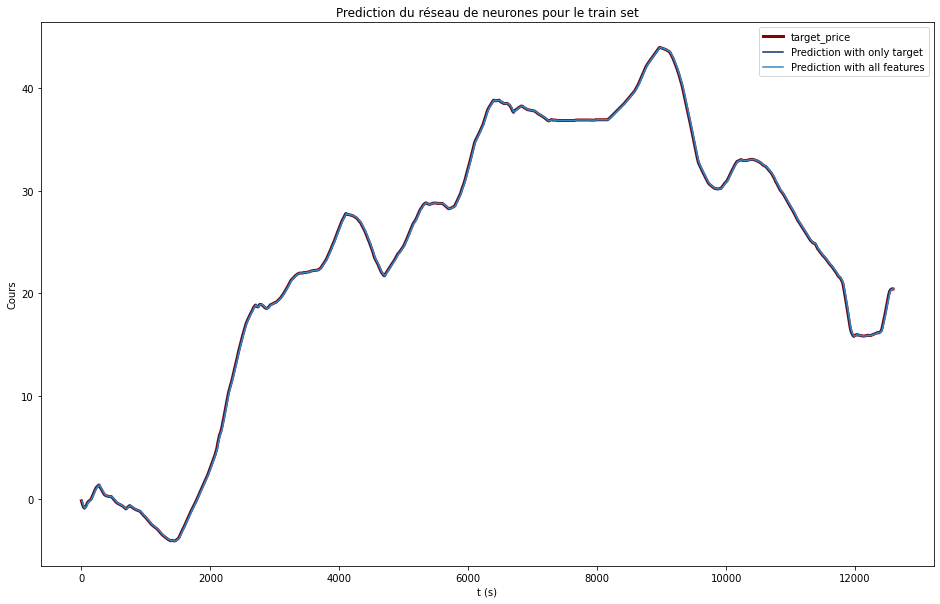

In [37]:
plot_nn_model_prediction(TrainTS, 'Prediction du réseau de neurones pour le train set')

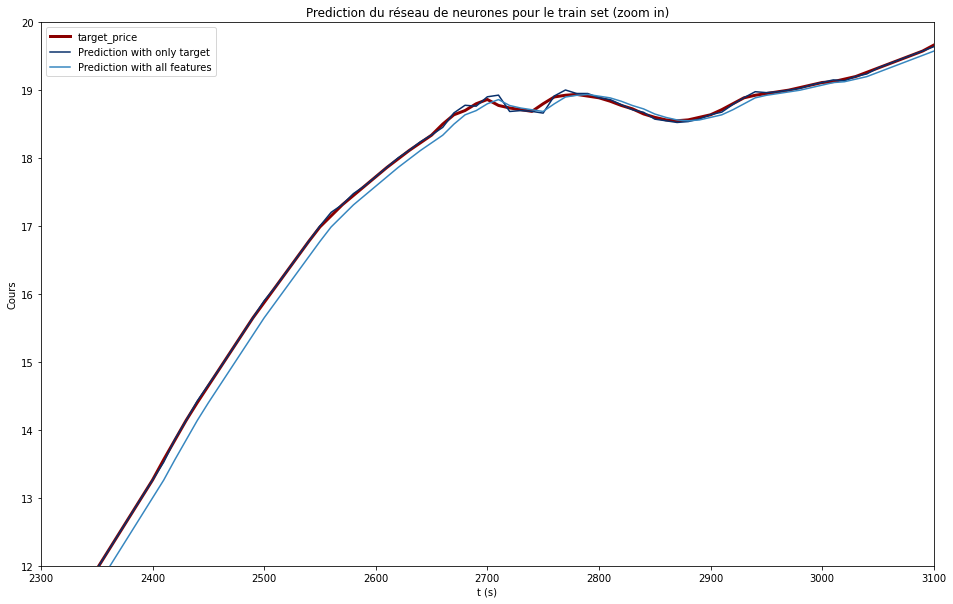

In [38]:
plot_nn_model_prediction(TrainTS, 'Prediction du réseau de neurones pour le train set (zoom in)', (2300, 3100), (12, 20))

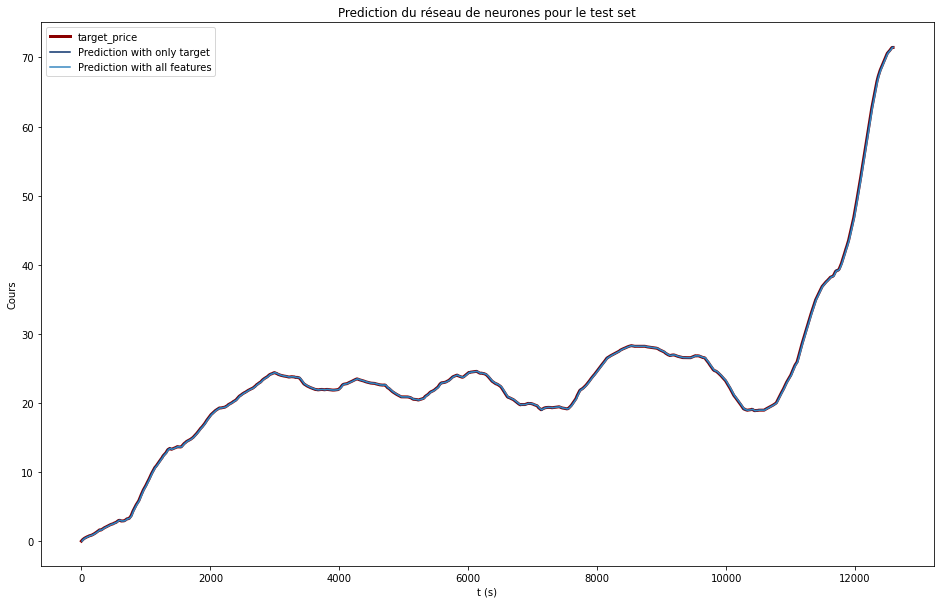

In [39]:
plot_nn_model_prediction(TestTS, 'Prediction du réseau de neurones pour le test set')

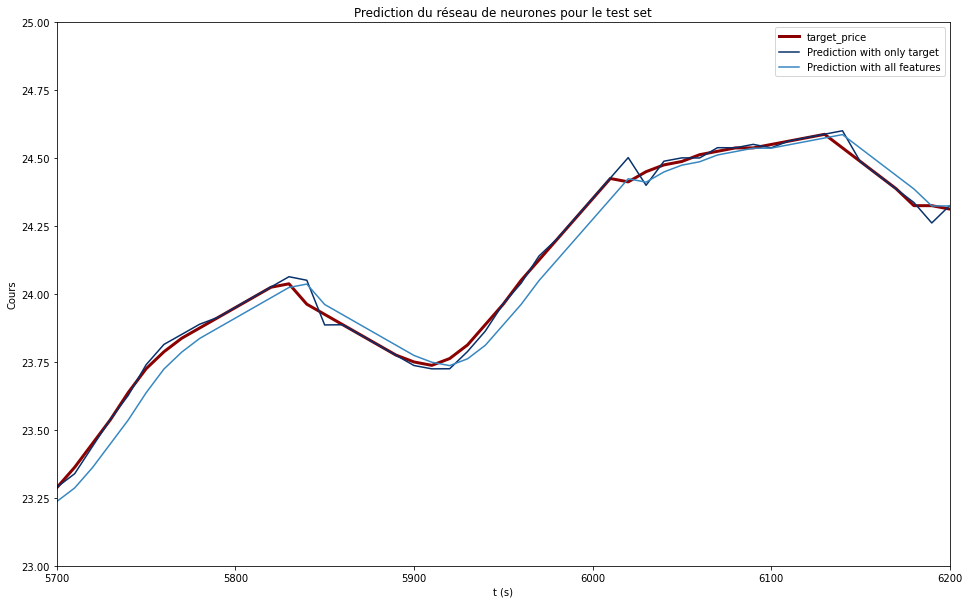

In [40]:
plot_nn_model_prediction(TestTS, 'Prediction du réseau de neurones pour le test set', (5700, 6200), (23, 25))

### Performance

Dans cette section, nous étudions la performance du modèle de réseau de neurones.

In [41]:
from Classes.PerformanceClass import PerformanceClass

In [42]:
perf_train_list = []
perf_test_list = []

df_prediction_target = TrainTS.data['nn_model_inertia_like']
perf_train_list.append(PerformanceClass().get_euclidean_distance(TrainTS.data['target'], df_prediction_target))

df_prediction_target = TrainTS.data['nn_model_all_features']
perf_train_list.append(PerformanceClass().get_euclidean_distance(TrainTS.data['target'], df_prediction_target))

df_prediction_target = TestTS.data['nn_model_inertia_like']
perf_test_list.append(PerformanceClass().get_euclidean_distance(TestTS.data['target'], df_prediction_target))

df_prediction_target = TestTS.data['nn_model_all_features']
perf_test_list.append(PerformanceClass().get_euclidean_distance(TestTS.data['target'], df_prediction_target))
    

L'histogramme suivant donne la performance du modèle pour les deux différents jeu de features sur le training set et le test set. Les lignes verticales donnent la meilleure performance du modèle d'inertie pour chacun des deux set. Il en sort que le modèle d'inertie a une meilleure performance que le modèle de réseau de neurones surtout pour le test set.

<ipython-input-44-b862eb768a9c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['only target', 'all features'])


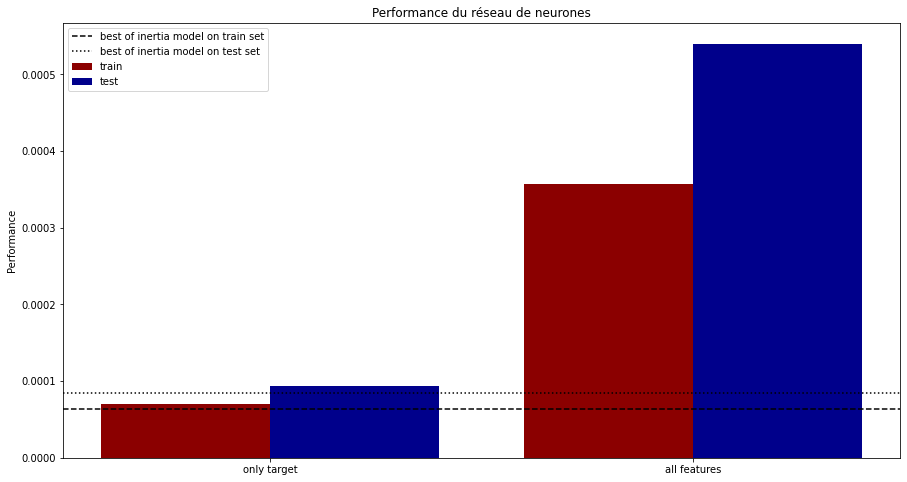

In [44]:
fig, ax = pb.subplots(figsize=(15, 8))

dx = 0.1
x = .25

pb.bar([-dx, x-dx], perf_train_list, width=dx, color='darkred', label='train')
pb.bar([0, x], perf_test_list, width=dx, color='darkblue', label='test')

ax.set_xticklabels(['only target', 'all features'])
ax.set_xticks([-dx/2, x-dx/2])
ax.set_ylabel('Performance')

pb.axhline(best_inertia_perf_on_train_set, label='best of inertia model on train set', c='k', ls='--')
pb.axhline(best_inertia_perf_on_test_set, label='best of inertia model on test set', c='k', ls=':')

pb.title('Performance du réseau de neurones')

pb.legend()

## Stochasticité du modèle

Dû à la nature stochastique de l'entrainement du réseau de neurones, les résultats du modèle ne sont pas constants. Il peut donner des prédictions satisfaisantes, comme proposer un cours totalement décalé par rapport au cours de *target*.

Je pense que cela est dû à la présence de nombreux minimaux locaux dans la fonction de coût correspondants aux cas où la prédiction est un décalage de *target*. En effet, *target* étant fortement autocorrélé, la distance entre sa valeur et ses valeurs décalées dans le temps reste faible.

Une façon d'y remédier serait de choisir une fonction de coûx qui pénalise les solutions qui sont des décalages de *target* sans être *target* lui-même.

Il est à noter que plus il y a de features, plus la qualité des résultats est aléatoire.

## Conclusion

L'auto-correlation de *target* est telle que sa valeur à l'instant précédant est une bonne prédiction de sa valeur présente. Toutefois, cette prédiction laisse à désirer lors de fort changement de valeur de *target*.


Même si le modèle d'inertie montre le contraire, j'ai l'intuition qu'utiliser des valeurs plus antérieures à $t-dt$ peut aider à la prédiction de *target*, en exploitant mieux l'inertie de *target*. En effet, le cours de target décélère avant chaque changement de signe. Utiliser l'accélération du cours de *target* (i.e. la première différence de *target*) pourrait aider à mieux le prédire.


Il faudrait concevoir un modèle qui apprennent la forme de la décélération à partir des premières secondes de son amorce, ou peut-être peut on apprendre la forme d'une décélération en connaissant la forme de la décélération précédante.

J'ai bien conscience que ce genre de méthodes fonctionne, car *target* est lisse. Elle ne fonctionneraient moins bien sur des signaux plus bruités comme les cours de référence et alternatif.

Les cours de référence et alternatifs sont fortement corrélés avec *target*, mais avec 5 minutes de retard. Il est donc peu probable qu'ils aient une valeur prédictive. D'ailleurs utiliser ces features dans un modèle de réseaux de neurones n'a pas aidé à mieux prédire *target*.

Toutefois, dans cette version de réseau de neurones, je n'utilise que les valeurs à l'instant $t-dt$. Peut-être utiliser des valeurs antécédantes pourraient aider. On peut dors et déjà les ajouter aux features utilisées dans le modèle de réseau de neurones. Mais ainsi on ne garde pas le caractére séquentiel des time series. Pour cela, il faut faire appel à des modèles plus sophistiqués de deep learning comme les LSTM ou bien ceux utilisés en NLP.

## Annexe

### Heure, jour de la semaine et mois

J'ai regardé si l'heure, le jour de la semaine et le mois ont une influence sur les données. Pour cela, j'ai tracé la distribution de *target* pour chaque jour de la semaine, chaque mois et chaque heure de la journée.

In [45]:
TrainTS.compute_month_weekday_and_month_columns()
TestTS.compute_month_weekday_and_month_columns()

Selon les figures suivantes, la distribution de *target* semble peut différer en fonction du jour de la semaine.

En revanche, les distributions pendant les heures 14 et 18 semblent légèrement différentes du reste de la journée. 

Les distributions se répartissent en trois catégories en fonction des mois. Les mois de janvier, avril, mai et juin d'une part; février et mars d'autre part; et enfin juillet, aout et septembre forment la dernière catégorie.

**Pour conclure**, l'heure et le mois sont éventuellement des features à prendre en compte pour prédire *target*. Toutefois, il faudrait une analyse plus poussée pour approfondir ce point. Par exemple en effectuant des tests pour vérifier si ces distributions sont statistiquement disembables. Mais plus important, il faut voir en pratique si intégrer ces features dans un modèle améliore la performance.

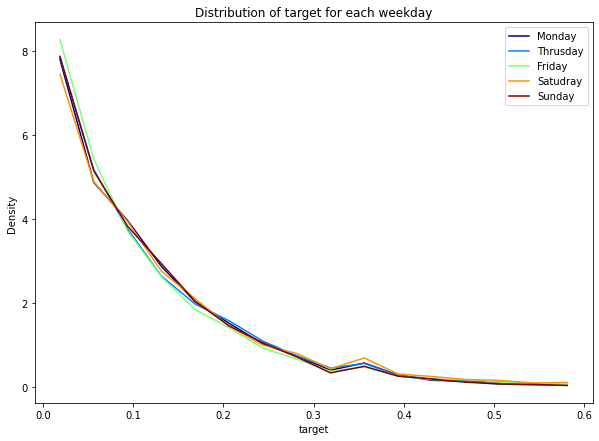

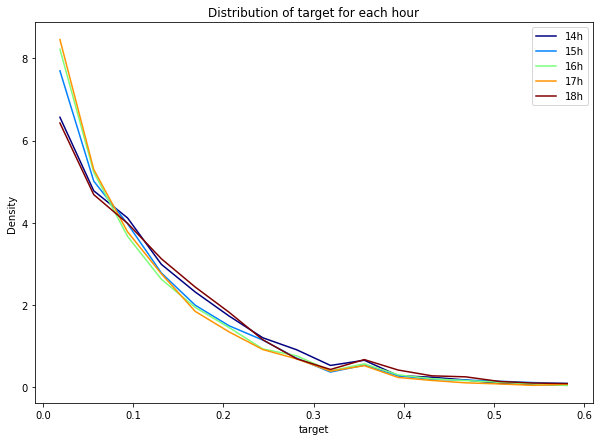

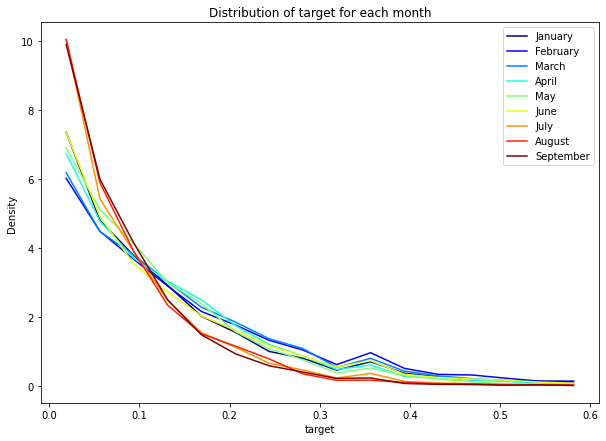

In [46]:
def plot_target_for_each(name, label_list):
        
    dx = 0.0125*3
    bins = np.arange(0, 0.6+dx, dx)
    x = (bins[1:]+bins[:-1])/2.
    
    category_list = TrainTS.data[name].unique()
    category_list.sort()
        
    color_dict = Tools().get_list_color('jet', category_list)
    fig, ax = pb.subplots(figsize=(10, 7))
    
    for category in category_list:
        vals = TrainTS.data['target'][TrainTS.data[name] == category].abs().values
        y, _ = np.histogram(vals, bins, density=True)
        ax.plot(x, y, label=label_list[category], c=color_dict[str(category)])
    
    pb.title('Distribution of target for each %s' % name)
    pb.xlabel('target')
    pb.ylabel('Density')
    pb.legend()
    pb.show()

plot_target_for_each('weekday', {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thrusday', 4: 'Friday', 5: 'Satudray', 6:'Sunday'})
plot_target_for_each('hour', {h: str(h)+'h' for h in range(14, 20)})
plot_target_for_each('month', {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6:'June', 7: 'July', 8: 'August', 9: 'September'})